<a href="https://colab.research.google.com/github/judex22/CIFAR10-Image-Classification-with-DeepLearning/blob/main/Fake_News_Detection_Trigram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection (Trigram BOW)

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [ ]:
!pip install nltk

In [ ]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\jude
[nltk_data]     sequeira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\jude
[nltk_data]     sequeira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\jude
[nltk_data]     sequeira\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\jude
[nltk_data]     sequeira\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path,encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))





def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))

    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))




# Question 1: Input and Basic preprocessing (10 marks)

In [ ]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):

    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    l=data_line[1]


    if (l=="true")or(l=="mostly-true")or(l=="half-true")or(l=="false")or(l=="barely-true")or(l=="pants-fire"):
        Label=convert_label(l)
        sent=data_line[2]


    return (Label,sent)

In [ ]:
import string
import regex as re


# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS

    text=text.translate(str.maketrans('','',string.punctuation))
    tokens = re.split(r"\s+",text)
    tokens= [x.lower() for x in tokens]
    stop_words=set(stopwords.words("english"))
    tokens=[i for i in tokens if i not in stop_words]
    lemmatizer=WordNetLemmatizer()
    tokens=[lemmatizer.lemmatize(w,pos='v') for w in tokens]
    if False:

        print("Output after PreProcessing Tokens:\n",tokens)

    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):



    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS

    featureDict = {}  # Global feature dictionary maps from words/features to unique index
    i = 0 # index counter variable for the global feature dict


    """Convert word tokens into a feature vector dictionary of
    feature index keys and weight values.

    Update the featureVector if in training phase, i.e. where training=True.
    """

    featureVector = {}                       # local feature vector for this example (in dict form)

    def generate_N_grams(text,ngram):                #function to get N-gram tokens(in this case N=3 i:e Trigram)

        words=text
        temp=zip(*[words[i:] for i in range(0,ngram)])
        ans=[' '.join(ngram) for ngram in temp]

        return ans

    trigram_token=generate_N_grams(tokens,3)


    for w in trigram_token:

        # First add to the global feature dictionary, and give it a position
        # if in training
        try:
            # if the word w is in the dictionary,
            # then assign i to its value in the dictionary
            i = featureDict[w]
        except KeyError:
            # else if it's not in the dictionary,
            # it's a new feature in training, add new entry
            i = len(featureDict) + 1
            featureDict[w] = i


        # Add to local feature vector (as a dictionary entry with a weight)

        try:
            # if the word w is in the local feature vector (repeat word), add 1/n weight
            featureVector[i] += 1 #(1.0/len(words))
        except KeyError:
            # else if it's not in the local feature vector, create the entry with 1/n weight
            featureVector[i] = 1 #(1.0/len(words))

        if False:
            # example binary alternative to the above (just add it as 1 if present)
            if not i in featureVector.keys():
                featureVector[i] = 1
    print("Feature Dictionary of Trigram BOW model\n",featureDict)
    print("Feature Vector of Trigram BOW model\n",featureVector,"\n")

    return featureVector






In [ ]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [ ]:
#solution
from sklearn import metrics
from sklearn.metrics import classification_report
from statistics import mean


def cross_validate(dataset, folds):

    train=dataset
    results =[]
    cv_results=[]
    cv=[]
    prec=[]
    rec=[]
    f1=[]



    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset


        k_test= train[i:fold_size+i]
        k_train= train[0:i]+train[fold_size+i: ]

        k_train_label=[]
        k_test_label=[]


        for j in range(0,len(k_test)):
            k_test_label.append(k_test[j][1])

        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE

        classifier = train_classifier(k_train)
        k_test_true = k_test_label                   # get the ground-truth labels from the data
        k_test_pred = predict_labels([x[0] for x in k_test], classifier)

        results = precision_recall_fscore_support(k_test_true, k_test_pred ,average= 'weighted' )
        cv.append(results)

        if True:
            print("Precision: %f\nRecall: %f\nF Score:%f \n" % results[:3])
            print("Classification Report on 10 fold CV Test Data:\n",classification_report(k_test_true, k_test_pred) ,"\n")


    for q in range(0,10):
        prec.append(cv[q][0])
        rec.append(cv[q][1])
        f1.append(cv[q][2])

    prec_avg=mean(prec)
    rec_avg=mean(rec)
    f1_avg=mean(f1)


    cv_results=[prec_avg,rec_avg,f1_avg]

    print("\n\n The Average of Precision Recall F1 score across all 10 folds of Cross Validation:")
    return cv_results

In [ ]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [ ]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
Feature Dictionary of Trigram BOW model
 {'say annies list': 1, 'annies list political': 2, 'list political group': 3, 'political group support': 4, 'group support thirdtrimester': 5, 'support thirdtrimester abortions': 6, 'thirdtrimester abortions demand': 7}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1} 

Feature Dictionary of Trigram BOW model
 {'decline coal start': 1, 'coal start start': 2, 'start start natural': 3, 'start natural gas': 4, 'natural gas take': 5, 'gas take start': 6, 'take start begin': 7, 'start begin president': 8, 'begin president george': 9, 'president george w': 10, 'george w bush': 11, 'w bush administration': 12}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1} 

Feature Dictionary of Trigram BOW model
 {'hillary clinton 

Feature Dictionary of Trigram BOW model
 {'im one whos': 1, 'one whos fight': 2, 'whos fight developers': 3, 'fight developers drain': 4, 'developers drain everglades': 5}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1} 

Feature Dictionary of Trigram BOW model
 {'say ron johnson': 1, 'ron johnson call': 2, 'johnson call social': 3, 'call social security': 4, 'social security ponzi': 5, 'security ponzi scheme': 6, 'ponzi scheme want': 7, 'scheme want privatize': 8, 'want privatize program': 9}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} 

Feature Dictionary of Trigram BOW model
 {'31 state 10000': 1, 'state 10000 cities': 2, '10000 cities type': 3, 'cities type policies': 4, 'type policies pass': 5, 'policies pass refer': 6, 'pass refer north': 7, 'refer north carolinas': 8, 'north carolinas house': 9, 'carolinas house bill': 10, 'house bill 2': 11}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6:

Feature Dictionary of Trigram BOW model
 {'salaries uri faculty': 1, 'uri faculty second': 2, 'faculty second last': 3, 'second last among': 4, 'last among new': 5, 'among new england': 6, 'new england land': 7, 'england land grant': 8, 'land grant universities': 9, 'grant universities lowest': 10, 'universities lowest 20': 11, 'lowest 20 percent': 12, '20 percent major': 13, 'percent major us': 14, 'major us research': 15, 'us research institutions': 16}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1} 

Feature Dictionary of Trigram BOW model
 {'say miami congressman': 1, 'miami congressman carlos': 2, 'congressman carlos curbelo': 3, 'carlos curbelo support': 4, 'curbelo support drill': 5, 'support drill offshore': 6, 'drill offshore repeatedly': 7, 'offshore repeatedly vote': 8, 'repeatedly vote president': 9, 'vote president obamas': 10, 'president obamas ability': 11, 'obamas ability fight

Feature Dictionary of Trigram BOW model
 {'say president obama': 1, 'president obama waive': 2, 'obama waive work': 3, 'waive work requirement': 4, 'work requirement welfare': 5}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1} 

Feature Dictionary of Trigram BOW model
 {'7 10 oregon': 1, '10 oregon families': 2, 'oregon families live': 3, 'families live poverty': 4, 'live poverty least': 5, 'poverty least one': 6, 'least one parent': 7, 'one parent work': 8}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} 

Feature Dictionary of Trigram BOW model
 {'ninetyseven percent time': 1, 'percent time thats': 2, 'time thats often': 3, 'thats often mark': 4, 'often mark warner': 5, 'mark warner vote': 6, 'warner vote president': 7, 'vote president obama': 8}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} 

Feature Dictionary of Trigram BOW model
 {'say rick perry': 1, 'rick perry 25year': 2, 'perry 2

Feature Dictionary of Trigram BOW model
 {'jeff greene move': 1, 'greene move california': 2, 'move california florida': 3, 'california florida last': 4, 'florida last two': 5, 'last two years': 6, 'two years fact': 7, 'years fact would': 8, 'fact would legally': 9, 'would legally allow': 10, 'legally allow run': 11, 'allow run statewide': 12, 'run statewide office': 13, 'statewide office live': 14, 'office live long': 15, 'live long enough': 16, 'long enough meet': 17, 'enough meet residency': 18, 'meet residency requirement': 19}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1} 

Feature Dictionary of Trigram BOW model
 {'president obama increase': 1, 'obama increase federal': 2, 'increase federal workforce': 3, 'federal workforce 192000': 4, 'workforce 192000 individuals': 5, '192000 individuals 10': 6, 'individuals 10 percent': 7, '10 percent since': 8, 'percent since he

Feature Dictionary of Trigram BOW model
 {'say families pay': 1, 'families pay 40': 2, 'pay 40 percent': 3, '40 percent income': 4, 'percent income tax': 5}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1} 

Feature Dictionary of Trigram BOW model
 {'say hillary clinton': 1, 'hillary clinton negotiate': 2, 'clinton negotiate first': 3, 'negotiate first agreement': 4, 'first agreement ever': 5, 'agreement ever china': 6, 'ever china india': 7, 'china india officially': 8, 'india officially commit': 9, 'officially commit reduce': 10, 'commit reduce emissions': 11}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1} 

Feature Dictionary of Trigram BOW model
 {'incoming republican freshman': 1, 'republican freshman class': 2, 'freshman class well': 3, 'class well ordinary': 4, 'well ordinary group': 5, 'ordinary group nearly': 6, 'group nearly half': 7, 'nearly half roughly': 8, 'half roughly 80': 9, 'roughly 80 membe

Feature Dictionary of Trigram BOW model
 {'fence work great': 1, 'work great wall': 2, 'great wall china': 3, 'wall china berlin': 4, 'china berlin wall': 5, 'berlin wall thats': 6, 'wall thats good': 7, 'thats good among': 8, 'good among people': 9, 'among people especially': 10, 'people especially friends': 11, 'especially friends like': 12, 'friends like unite': 13, 'like unite state': 14, 'unite state mexico': 15}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1} 

Feature Dictionary of Trigram BOW model
 {'say require state': 1, 'require state septic': 2, 'state septic inspections': 3, 'septic inspections would': 4, 'inspections would cost': 5, 'would cost septic': 6, 'cost septic tank': 7, 'septic tank owners': 8, 'tank owners 100': 9, 'owners 100 150': 10, '100 150 every': 11, '150 every five': 12, 'every five years': 13}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7

Feature Dictionary of Trigram BOW model
 {'bill advance keystone': 1, 'advance keystone xl': 2, 'keystone xl pipeline': 3, 'xl pipeline earmark': 4, 'pipeline earmark house': 5, 'earmark house rule': 6}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1} 

Feature Dictionary of Trigram BOW model
 {'say rick scott': 1, 'rick scott think': 2, 'scott think employers': 3, 'think employers able': 4, 'employers able deny': 5, 'able deny women': 6, 'deny women coverage': 7, 'women coverage birth': 8, 'coverage birth control': 9}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} 

Feature Dictionary of Trigram BOW model
 {'florida first state': 1, 'first state require': 2, 'state require drug': 3, 'require drug test': 4, 'drug test receive': 5, 'test receive welfare': 6}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1} 

Feature Dictionary of Trigram BOW model
 {'say hillary clinton': 1, 'hillary clinton w

Feature Dictionary of Trigram BOW model
 {'preventive care save': 1, 'care save money': 2}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1} 

Feature Dictionary of Trigram BOW model
 {'say connie mack': 1, 'connie mack iv': 2, 'mack iv cosponsor': 3, 'iv cosponsor bill': 4, 'cosponsor bill take': 5, 'bill take third': 6, 'take third social': 7, 'third social security': 8, 'social security trust': 9, 'security trust fund': 10, 'trust fund give': 11, 'fund give individual': 12, 'give individual account': 13, 'individual account senior': 14, 'account senior citizens': 15, 'senior citizens invest': 16, 'citizens invest stock': 17, 'invest stock market': 18}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1} 

Feature Dictionary of Trigram BOW model
 {'national guard saw': 1, 'guard saw midwest': 2, 'saw midwest flood': 3, 'midwest flood cant': 4, 'flood cant function': 5, 'cant function

Feature Dictionary of Trigram BOW model
 {'obamacare pass one': 1, 'pass one vote': 2, 'one vote senate': 3, 'vote senate wouldnt': 4, 'senate wouldnt pass': 5, 'wouldnt pass without': 6, 'pass without mark': 7, 'without mark warners': 8, 'mark warners vote': 9}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} 

Feature Dictionary of Trigram BOW model
 {'say adam hasners': 1, 'adam hasners record': 2, 'hasners record include': 3, 'record include request': 4, 'include request 922': 5, 'request 922 million': 6, '922 million earmark': 7}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1} 

Feature Dictionary of Trigram BOW model
 {'one betatested healthcaregov': 1}
Feature Vector of Trigram BOW model
 {1: 1} 

Feature Dictionary of Trigram BOW model
 {'susie lee husband': 1, 'lee husband 17': 2, 'husband 17 home': 3, '17 home across': 4, 'home across country': 5, 'across country use': 6, 'country use private': 7, 'use

Feature Dictionary of Trigram BOW model
 {'baucus bill federal': 1, 'bill federal fund': 2, 'federal fund would': 3, 'fund would subsidize': 4, 'would subsidize coverage': 5, 'subsidize coverage elective': 6, 'coverage elective abortions': 7}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1} 

Feature Dictionary of Trigram BOW model
 {'four balance budget': 1, 'balance budget row': 2, 'budget row new': 3, 'row new tax': 4, 'new tax anyone': 5, 'tax anyone best': 6, 'anyone best job': 7, 'best job growth': 8, 'job growth 12': 9, 'growth 12 years': 10, '12 years nearly': 11, 'years nearly 130000': 12, 'nearly 130000 new': 13, '130000 new privatesector': 14, 'new privatesector job': 15, 'privatesector job merit': 16, 'job merit pay': 17, 'merit pay reward': 18, 'pay reward new': 19, 'reward new jerseys': 20, 'new jerseys best': 21, 'jerseys best teachers': 22, 'best teachers education': 23, 'teachers education fund': 24, 'education fund ever': 25}
Feature Vec

Feature Dictionary of Trigram BOW model
 {'anybody whos try': 1, 'whos try cross': 2, 'try cross street': 3, 'cross street see': 4, 'street see sign': 5, 'see sign say': 6, 'sign say stop': 7, 'say stop pedestrians': 8, 'stop pedestrians crosswalk': 9, 'pedestrians crosswalk bill': 10, 'crosswalk bill pass': 11}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1} 

Feature Dictionary of Trigram BOW model
 {'poll show 96': 1, 'show 96 percent': 2, '96 percent new': 3, 'percent new jerseyans': 4, 'new jerseyans 95': 5, 'jerseyans 95 percent': 6, '95 percent gun': 7, 'percent gun households': 8, 'gun households state': 9, 'households state support': 10, 'state support expand': 11, 'support expand background': 12, 'expand background check': 13, 'background check keep': 14, 'check keep gun': 15, 'keep gun away': 16, 'gun away shouldnt': 17}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1,

Feature Dictionary of Trigram BOW model
 {'2009 dozens senior': 1, 'dozens senior terrorists': 2, 'senior terrorists take': 3, 'terrorists take battlefield': 4, 'take battlefield drone': 5}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1} 

Feature Dictionary of Trigram BOW model
 {'say tommy thompson': 1, 'tommy thompson favor': 2, 'thompson favor obamas': 3, 'favor obamas health': 4, 'obamas health care': 5, 'health care mandate': 6, 'care mandate publicly': 7, 'mandate publicly thank': 8, 'publicly thank obama': 9, 'thank obama health': 10, 'obama health reform': 11, 'health reform support': 12, 'reform support thompson': 13, 'support thompson say': 14, 'thompson say cant': 15, 'say cant repeal': 16, 'cant repeal obamacare': 17}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1} 

Feature Dictionary of Trigram BOW model
 {'say state rep': 1, 'state rep jim': 2, 'rep ji

Feature Dictionary of Trigram BOW model
 {'pres obamas finance': 1, 'obamas finance team': 2, 'finance team recommend': 3, 'team recommend 1': 4, 'recommend 1 tax': 5, '1 tax transactions': 6, 'tax transactions financial': 7, 'transactions financial institution': 8}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} 

Feature Dictionary of Trigram BOW model
 {'say new national': 1, 'new national poll': 2, 'national poll show': 3, 'poll show majority': 4, 'show majority american': 5, 'majority american people': 6, 'american people believe': 7, 'people believe gold': 8, 'believe gold standard': 9, 'gold standard us': 10, 'standard us currency': 11}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1} 

Feature Dictionary of Trigram BOW model
 {'say barack obama': 1, 'barack obama try': 2, 'obama try slash': 3, 'try slash fund': 4, 'slash fund arm': 5, 'fund arm pilot': 6, 'arm pilot program': 7, 'pilo

Feature Dictionary of Trigram BOW model
 {'say new health': 1, 'new health care': 2, 'health care law': 3, 'care law deliver': 4, 'law deliver 13': 5, 'deliver 13 billion': 6, '13 billion tax': 7, 'billion tax increase': 8, 'tax increase families': 9, 'increase families special': 10, 'families special need': 11}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1} 

Feature Dictionary of Trigram BOW model
 {'say every year': 1, 'every year air': 2, 'year air pollution': 3, 'air pollution protections': 4, 'pollution protections delay': 5, 'protections delay another': 6, 'delay another 34000': 7, 'another 34000 people': 8, '34000 people die': 9, 'people die prematurely': 10}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1} 

Feature Dictionary of Trigram BOW model
 {'tampa bay ray': 1, 'bay ray price': 2, 'ray price judge': 3, 'price judge affordable': 4, 'judge affordable professional'

Feature Dictionary of Trigram BOW model
 {'say chris christie': 1, 'chris christie fire': 2, 'christie fire 6000': 3, 'fire 6000 teachers': 4}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1} 

Feature Dictionary of Trigram BOW model
 {'currently take 25': 1, 'take 25 years': 2, '25 years obtain': 3, 'years obtain us': 4, 'obtain us citizenship': 5, 'us citizenship legally': 6, 'citizenship legally senate': 7, 'legally senate bill': 8, 'senate bill would': 9, 'bill would allow': 10, 'would allow immigrants': 11, 'allow immigrants come': 12, 'immigrants come unite': 13, 'come unite state': 14, 'unite state illegally': 15, 'state illegally obtain': 16, 'illegally obtain citizenship': 17, 'obtain citizenship 13': 18, 'citizenship 13 years': 19}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1} 

Feature Dictionary of Trigram BOW model
 {'homeopathy acupuncture aroma

Feature Dictionary of Trigram BOW model
 {'25 wealthiest nations': 1, 'wealthiest nations one': 2, 'nations one doesnt': 3, 'one doesnt provide': 4, 'doesnt provide basic': 5, 'provide basic health': 6, 'basic health coverage': 7}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1} 

Feature Dictionary of Trigram BOW model
 {'13 percent americans': 1, 'percent americans lowest': 2, 'americans lowest ever': 3, 'lowest ever without': 4, 'ever without health': 5, 'without health care': 6}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1} 

Feature Dictionary of Trigram BOW model
 {'say romney support': 1, 'romney support law': 2, 'support law could': 3, 'law could make': 4, 'could make common': 5, 'make common form': 6, 'common form birth': 7, 'form birth control': 8, 'birth control illegal': 9}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} 

Feature Dictionary of Trigram BOW model
 {'public 

Feature Dictionary of Trigram BOW model
 {'say donald trump': 1, 'donald trump bring': 2, 'trump bring hundreds': 3, 'bring hundreds foreign': 4, 'hundreds foreign workers': 5, 'foreign workers replace': 6, 'workers replace americans': 7}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1} 

Feature Dictionary of Trigram BOW model
 {'tuitionfree public universities': 1, 'public universities colleges': 2, 'universities colleges pipe': 3, 'colleges pipe dream': 4, 'pipe dream false': 5, 'dream false free': 6, 'false free vietnam': 7, 'free vietnam war': 8}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} 

Feature Dictionary of Trigram BOW model
 {'candidate bill byrne': 1, 'bill byrne use': 2, 'byrne use campaign': 3, 'use campaign fund': 4, 'campaign fund work': 5, 'fund work personal': 6, 'work personal car': 7}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1} 

Feature Dictionary of Trigra

Feature Dictionary of Trigram BOW model
 {'seventy percent texans': 1, 'percent texans overweight': 2, 'texans overweight obese': 3}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1} 

Feature Dictionary of Trigram BOW model
 {'say water fluoridation': 1, 'water fluoridation start': 2, 'fluoridation start nazi': 3, 'start nazi germany': 4, 'nazi germany ghettos': 5, 'germany ghettos death': 6, 'ghettos death camp': 7, 'death camp pacify': 8, 'camp pacify jews': 9}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} 

Feature Dictionary of Trigram BOW model
 {'say plan would': 1, 'plan would cut': 2, 'would cut tax': 3, 'cut tax without': 4, 'tax without increase': 5, 'without increase deficit': 6}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1} 

Feature Dictionary of Trigram BOW model
 {'senior senator arizona': 1, 'senator arizona john': 2, 'arizona john mccain': 3, 'john mccain say': 4, 'mccain say couldnt': 5, 

Feature Dictionary of Trigram BOW model
 {'georgia lawmakers balance': 1, 'lawmakers balance budget': 2, 'balance budget without': 3, 'budget without raise': 4, 'without raise tax': 5, 'raise tax residents': 6}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1} 

Feature Dictionary of Trigram BOW model
 {'defend vote push': 1, 'vote push retirement': 2, 'push retirement age': 3, 'retirement age 70': 4, 'age 70 say': 5, '70 say process': 6, 'say process would': 7, 'process would fully': 8, 'would fully implement': 9, 'fully implement around': 10, 'implement around turn': 11, 'around turn century': 12}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1} 

Feature Dictionary of Trigram BOW model
 {'president obama want': 1, 'obama want mandate': 2, 'want mandate circumcision': 3}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1} 

Feature Dictionary of Trigram BOW model
 {'president give 1100': 1, 'g

Feature Dictionary of Trigram BOW model
 {'say 38 billion': 1, '38 billion spend': 2, 'billion spend cut': 3, 'spend cut federal': 4, 'cut federal budget': 5, 'federal budget compromise': 6, 'budget compromise less': 7, 'compromise less 1': 8, 'less 1 billion': 9, '1 billion real': 10, 'billion real cut': 11}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1} 

Feature Dictionary of Trigram BOW model
 {'eightyfive percent governments': 1, 'percent governments run': 2, 'governments run right': 3, 'run right 15': 4, 'right 15 percent': 5, '15 percent government': 6, 'percent government spend': 7, 'government spend shut': 8}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} 

Feature Dictionary of Trigram BOW model
 {'epa try define': 1, 'try define puddle': 2, 'define puddle drainage': 3, 'puddle drainage ditch': 4, 'drainage ditch farm': 5, 'ditch farm navigable': 6, 'farm navigable water': 7, 'na

Feature Dictionary of Trigram BOW model
 {'say president barack': 1, 'president barack obama': 2, 'barack obama propose': 3, 'obama propose one': 4, 'propose one thing': 5, 'one thing would': 6, 'thing would change': 7, 'would change fact': 8, 'change fact warren': 9, 'fact warren buffett': 10, 'warren buffett pay': 11, 'buffett pay lower': 12, 'pay lower tax': 13, 'lower tax rate': 14, 'tax rate secretary': 15}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1} 

Feature Dictionary of Trigram BOW model
 {'300000 floridians lose': 1, 'floridians lose health': 2, 'lose health insurance': 3, 'health insurance result': 4, 'insurance result obamacare': 5}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1} 

Feature Dictionary of Trigram BOW model
 {'say mitt romney': 1, 'mitt romney millions': 2, 'romney millions swiss': 3, 'millions swiss bank': 4, 'swiss bank account': 5}
Feature Vector of

Feature Dictionary of Trigram BOW model
 {'concern two sentence': 1, 'two sentence write': 2, 'sentence write minority': 3, 'write minority business': 4}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1} 

Feature Dictionary of Trigram BOW model
 {'say congressional budget': 1, 'congressional budget office': 2, 'budget office estimate': 3, 'office estimate capandtrade': 4, 'estimate capandtrade program': 5, 'capandtrade program would': 6, 'program would cost': 7, 'would cost average': 8, 'cost average family': 9, 'average family equivalent': 10, 'family equivalent postage': 11, 'equivalent postage stamp': 12, 'postage stamp day': 13}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1} 

Feature Dictionary of Trigram BOW model
 {'republicans majority rep': 1, 'majority rep barton': 2, 'rep barton would': 3, 'barton would actually': 4, 'would actually gavel': 5, 'actually gavel chairmanship': 6}
Feature Vecto

Feature Dictionary of Trigram BOW model
 {'say defense department': 1, 'defense department shrinkwrapped': 2, 'department shrinkwrapped 108': 3, 'shrinkwrapped 108 billion': 4, '108 billion american': 5, 'billion american money': 6, 'american money load': 7, 'money load 175': 8, 'load 175 pallets': 9, '175 pallets put': 10, 'pallets put transport': 11, 'put transport plane': 12, 'transport plane iraq': 13, 'plane iraq pass': 14, 'iraq pass 100': 15, 'pass 100 bill': 16, '100 bill one': 17, 'bill one receipt': 18}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1} 

Feature Dictionary of Trigram BOW model
 {'say stand party': 1, 'stand party vote': 2, 'party vote budget': 3, 'vote budget stop': 4, 'budget stop runaway': 5, 'stop runaway government': 6, 'runaway government spend': 7}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1} 

Feature Dictionary of

Feature Dictionary of Trigram BOW model
 {'first say would': 1, 'say would take': 2, 'would take troop': 3, 'take troop six': 4, 'troop six months': 5, 'six months acknowledge': 6, 'months acknowledge would': 7, 'acknowledge would take': 8, 'would take year': 9}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} 

Feature Dictionary of Trigram BOW model
 {'law mandate fingerprint': 1, 'mandate fingerprint gun': 2, 'fingerprint gun purchasers': 3, 'gun purchasers requirement': 4, 'purchasers requirement thats': 5, 'requirement thats reduce': 6, 'thats reduce gun': 7, 'reduce gun crimes': 8, 'gun crimes five': 9, 'crimes five state': 10, 'five state law': 11}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1} 

Feature Dictionary of Trigram BOW model
 {'one generation ago': 1, 'generation ago lead': 2, 'ago lead world': 3, 'lead world college': 4, 'world college graduation': 5, 'college gradua

Feature Dictionary of Trigram BOW model
 {'would love see': 1, 'love see us': 2, 'see us country': 3, 'us country help': 4, 'country help lead': 5, 'help lead arkansasamendment': 6, 'lead arkansasamendment 65': 7, 'arkansasamendment 65 say': 8, '65 say believe': 9, 'say believe life': 10, 'believe life begin': 11, 'life begin conception': 12, 'begin conception ought': 13, 'conception ought everything': 14, 'ought everything world': 15, 'everything world possible': 16, 'world possible protect': 17, 'possible protect natural': 18, 'protect natural conclusion': 19}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1} 

Feature Dictionary of Trigram BOW model
 {'go back obesity': 1, 'back obesity rat': 2, 'obesity rat exist': 3, 'rat exist back': 4, 'exist back 1980s': 5, 'back 1980s medicare': 6, '1980s medicare system': 7, 'medicare system several': 8, 'system several years': 9, '

Feature Dictionary of Trigram BOW model
 {'stimulus include 7': 1, 'include 7 million': 2, '7 million build': 3, 'million build bridge': 4, 'build bridge thedford': 5, 'bridge thedford nebraska': 6, 'thedford nebraska help': 7, 'nebraska help 168': 8, 'help 168 residents': 9, '168 residents avoid': 10, 'residents avoid 30second': 11, 'avoid 30second wait': 12, '30second wait local': 13, 'wait local train': 14, 'local train cross': 15, 'train cross one': 16, 'cross one fulltime': 17, 'one fulltime job': 18, 'fulltime job create': 19}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1} 

Feature Dictionary of Trigram BOW model
 {'obamacare isnt help': 1, 'isnt help anyone': 2}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1} 

Feature Dictionary of Trigram BOW model
 {'sixtyone percent active': 1, 'percent active military': 2, 'active military currently': 3, 'military currently 

Feature Dictionary of Trigram BOW model
 {'north carolina near': 1, 'carolina near national': 2, 'near national average': 3, 'national average unemployment': 4}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1} 

Feature Dictionary of Trigram BOW model
 {'obamacare include 700': 1, 'include 700 billion': 2, '700 billion cut': 3, 'billion cut medicare': 4, 'cut medicare seniors': 5}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1} 

Feature Dictionary of Trigram BOW model
 {'rate us female': 1, 'us female homicide': 2, 'female homicide victimsoutnumbers': 3, 'homicide victimsoutnumbers 24': 4, 'victimsoutnumbers 24 develop': 5, '24 develop countries': 6, 'develop countries 2': 7, 'countries 2 1': 8}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} 

Feature Dictionary of Trigram BOW model
 {'austin energy consider': 1, 'energy consider first': 2, 'consider first rate': 3, 'first rate increase': 4, 'rate increase since':

Feature Dictionary of Trigram BOW model
 {'cant bring ipad': 1, 'bring ipad piece': 2, 'ipad piece paper': 3, 'piece paper pencil': 4, 'paper pencil wisconsin': 5, 'pencil wisconsin assembly': 6, 'wisconsin assembly gallery': 7, 'assembly gallery take': 8, 'gallery take note': 9, 'take note whats': 10, 'note whats go': 11, 'whats go bring': 12, 'go bring gun': 13}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1} 

Feature Dictionary of Trigram BOW model
 {'passage clinton budget': 1, 'clinton budget bill': 2, 'budget bill 1993': 3, 'bill 1993 lead': 4, '1993 lead enormous': 5, 'lead enormous flower': 6, 'enormous flower economy': 7, 'flower economy america': 8}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} 

Feature Dictionary of Trigram BOW model
 {'say tear hundreds': 1, 'tear hundreds abandon': 2, 'hundreds abandon home': 3, 'abandon home serve': 4, 'home serve havens': 5, 

Feature Dictionary of Trigram BOW model
 {'mike morell testify': 1, 'morell testify tell': 2, 'testify tell congress': 3, 'tell congress reason': 4, 'congress reason obama': 5, 'reason obama bomb': 6, 'obama bomb isisoil': 7, 'bomb isisoil field': 8, 'isisoil field theyre': 9, 'field theyre concern': 10, 'theyre concern global': 11, 'concern global warm': 12}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1} 

Feature Dictionary of Trigram BOW model
 {'ohio company export': 1, 'company export goods': 2, 'export goods service': 3, 'goods service globally': 4, 'service globally 41': 5, 'globally 41 state': 6}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1} 

Feature Dictionary of Trigram BOW model
 {'say awho proposal': 1, 'awho proposal portray': 2, 'proposal portray milk': 3, 'portray milk dairy': 4, 'milk dairy products': 5, 'dairy products obstacle': 6, 'products obstacle healthy': 7, 'obstacle h

Feature Dictionary of Trigram BOW model
 {'study rank florida': 1, 'rank florida 1': 2, 'florida 1 government': 3, '1 government corruption': 4, 'government corruption gov': 5, 'corruption gov rick': 6, 'gov rick scott': 7}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1} 

Feature Dictionary of Trigram BOW model
 {'rhode island last': 1, 'island last state': 2, 'last state still': 3, 'state still use': 4, 'still use optech': 5, 'use optech iii': 6, 'optech iii p': 7, 'iii p vote': 8, 'p vote machine': 9, 'vote machine dont': 10, 'machine dont meet': 11, 'dont meet suggest': 12, 'meet suggest federal': 13, 'suggest federal standards': 14}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1} 

Feature Dictionary of Trigram BOW model
 {'obamacare cut 500': 1, 'cut 500 billion': 2, '500 billion future': 3, 'billion future medicare': 4, 'future medicare fund': 5, 'medicare fund order': 

Feature Dictionary of Trigram BOW model
 {'america lose 50000': 1, 'lose 50000 manufacture': 2, '50000 manufacture factories': 3, 'manufacture factories trade': 4, 'factories trade deal': 5}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1} 

Feature Dictionary of Trigram BOW model
 {'board nonprofit organization': 1, 'nonprofit organization obama': 2, 'organization obama serve': 3, 'obama serve pay': 4, 'serve pay director': 5, 'pay director grant': 6, 'director grant fund': 7, 'grant fund controversial': 8, 'fund controversial arab': 9, 'controversial arab group': 10}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1} 

Feature Dictionary of Trigram BOW model
 {'lose average 90': 1, 'average 90 americans': 2, '90 americans every': 3, 'americans every day': 4, 'every day gun': 5}
Feature Vector of Trigram BOW model
 {1: 1, 2: 1, 3: 1, 4: 1, 5: 1} 

Feature Dictionary of Trigram BOW model
 {'mccain vote bill': 1, 'vote b

In [ ]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Precision: 0.551800
Recall: 0.586585
F Score:0.450469 

Classification Report on 10 fold CV Test Data:
               precision    recall  f1-score   support

        FAKE       0.50      0.02      0.05       339
        REAL       0.59      0.98      0.74       481

    accuracy                           0.59       820
   macro avg       0.54      0.50      0.39       820
weighted avg       0.55      0.59      0.45       820
 

Fold start on items 820 - 1640
Training Classifier...
Precision: 0.525058
Recall: 0.542683
F Score:0.438400 

Classification Report on 10 fold CV Test Data:
               precision    recall  f1-score   support

        FAKE       0.50      0.08      0.14       375
        REAL       0.55      0.93      0.69       445

    accuracy                           0.54       820
   macro avg       0.52      0.51      0.42       820
weighted avg       0.53      0.54      0.44       820
 

Fold start on items 1640 - 24

[0.5377572555125357, 0.5636074732668509, 0.4408244305497541]

# 4. Error Analysis (10 marks)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Fold start on items 0 - 820
Training Classifier...


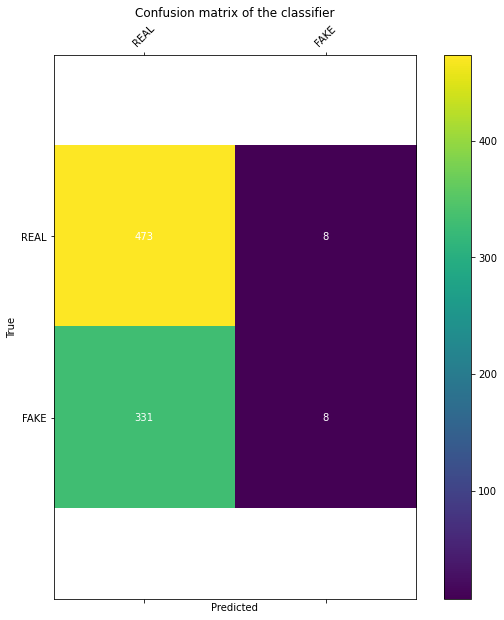

Accuracy of K-Fold Validation Data 0.5865853658536585


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
import statistics
r =[]

folds=10
fold_size = int(len(train_data)/folds) + 1
i=0




# confusion Matrix for first fold of 10 fold cross validation

k_test1= train_data[i:fold_size+i]
k_train1= train_data[0:i]+train_data[fold_size+i: ]

k_train_label1=[]
k_test_label1=[]


for j in range(0,len(k_test1)):
    k_test_label1.append(k_test1[j][1])

print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE

classifier1 = train_classifier(k_train1)
k_test_true1 = k_test_label1                   # get the ground-truth labels from the data
k_test_pred1 = predict_labels([x[0] for x in k_test1], classifier1)






labels=['REAL', 'FAKE']
confusion_matrix_heatmap(k_test_true1,k_test_pred1,labels)
print("Accuracy of K-Fold Validation Data",accuracy_score(k_test_true1,k_test_pred1))